# Imports

Most of the code in this notebook is taken from [pytorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Train and validation split

All of the images in the folder `ORIGINAL_DIR`. To split them into training and validation images and assign labels for them, this kind of directory structure is needed:

```
TEMP_DIR
|
|___train
|   |
|   |___working
|   |
|   |___crack
|
|___val
    |
    |___working
    |
    |___crack
```

In the end, `TEMP_DIR` can be deleted.

In [3]:
ORIGINAL_DIR = "images_for_model"
TEMP_DIR = "images_for_model_split"

WORKING = "working"
CRACK = "crack"

In [4]:
import os

def collect_file_paths(path: str, ext: str) -> list[str]:
    result = []
    
    for item in os.listdir(path):
        if item != ".ipynb_checkpoints":
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                result.extend(collect_file_paths(item_path, ext))
            elif item_path.endswith(ext):
                result.append(item_path)
                
    return result

In [6]:
import os
import shutil
from random import shuffle

def split_files(image_paths, working_dir, crack_dir):
    for path in image_paths:
        file_name = path.split("/")[-1]
        file_labels = file_name.split("_")

        if CRACK in file_labels:
            shutil.copyfile(path, os.path.join(crack_dir, file_name))
        else:
            shutil.copyfile(path, os.path.join(working_dir, file_name))
            
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

TRAIN_WORKING = os.path.join(TEMP_DIR, "train", WORKING)
TRAIN_CRACK = os.path.join(TEMP_DIR, "train", CRACK)
VAL_WORKING = os.path.join(TEMP_DIR, "val", WORKING)
VAL_CRACK = os.path.join(TEMP_DIR, "val", CRACK)

os.makedirs(TRAIN_WORKING)
os.makedirs(TRAIN_CRACK)
os.makedirs(VAL_WORKING)
os.makedirs(VAL_CRACK)

all_images = collect_file_paths(ORIGINAL_DIR, ".jpeg")
shuffle(all_images)
n_train = int(0.8 * len(all_images))

train_images = all_images[:n_train]
val_images = all_images[n_train:]

split_files(all_images[:n_train], TRAIN_WORKING, TRAIN_CRACK)
split_files(all_images[n_train:], VAL_WORKING, VAL_CRACK)

#### Show how many examples we have for each class in train and validation datasets

In [7]:
n_train_working = len(os.listdir(TRAIN_WORKING))
n_train_crack = len(os.listdir(TRAIN_CRACK))

n_val_working = len(os.listdir(VAL_WORKING))
n_val_crack = len(os.listdir(VAL_CRACK))

print("-------------")

print("Train images:")
print(WORKING + ": ", n_train_working)
print(CRACK + ": ", n_train_crack)
print("Total: ", n_train_working + n_train_crack)
      
print("-------------")

print("Validation images:")
print(WORKING + ": ", n_val_working)
print(CRACK + ": ", n_val_crack)
print("Total: ", n_val_working + n_val_crack)
      
print("-------------")

-------------
Train images:
working:  102
crack:  92
Total:  194
-------------
Validation images:
working:  30
crack:  19
Total:  49
-------------


# Load data

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = TEMP_DIR

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                              shuffle = True, num_workers = 2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cpu") # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

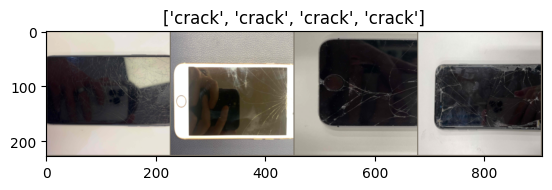

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Function to train the model

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Function to visualize model predictions

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Load a pretrained model and reset final fully connected layer.

In [19]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8451 Acc: 0.5567
val Loss: 0.5776 Acc: 0.7143

Epoch 1/24
----------
train Loss: 0.8269 Acc: 0.6753
val Loss: 0.4303 Acc: 0.8367

Epoch 2/24
----------
train Loss: 0.7075 Acc: 0.6237
val Loss: 0.4704 Acc: 0.7755

Epoch 3/24
----------
train Loss: 0.5928 Acc: 0.6907
val Loss: 0.8304 Acc: 0.6122

Epoch 4/24
----------
train Loss: 0.6956 Acc: 0.7113
val Loss: 0.7875 Acc: 0.7143

Epoch 5/24
----------
train Loss: 0.7389 Acc: 0.7062
val Loss: 0.7228 Acc: 0.7755

Epoch 6/24
----------
train Loss: 0.6003 Acc: 0.7165
val Loss: 0.4674 Acc: 0.7959

Epoch 7/24
----------
train Loss: 0.4625 Acc: 0.7887
val Loss: 0.5811 Acc: 0.7143

Epoch 8/24
----------
train Loss: 0.5476 Acc: 0.7216
val Loss: 0.5304 Acc: 0.7551

Epoch 9/24
----------
train Loss: 0.4742 Acc: 0.7526
val Loss: 0.6327 Acc: 0.6939

Epoch 10/24
----------
train Loss: 0.4983 Acc: 0.7887
val Loss: 0.4936 Acc: 0.7959

Epoch 11/24
----------
train Loss: 0.3618 Acc: 0.8505
val Loss: 0.5652 Acc: 0.7143

Ep

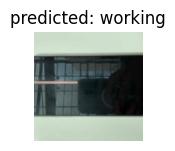

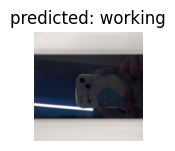

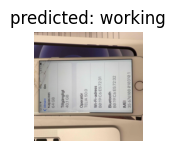

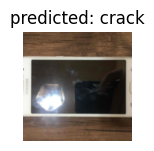

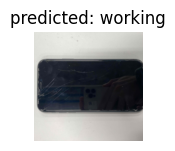

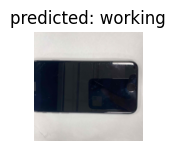

In [21]:
visualize_model(model_ft)